In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data import
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Preprocessing
#from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer


In [2]:
def anova_pvalue(df,cat_col,num_col):
    """
    This function spits out the anova p-value (probability of no correlation) 
    between a categorical column and a numerical column of a dataframe
    """
    CategoryGroupLists = df.groupby(cat_col)[num_col].apply(list)
    AnovaResults = ss.f_oneway(*CategoryGroupLists)
    p_value = round(AnovaResults[1],3)
    return p_value

In [3]:

#read csv fiel
df = pd.read_csv('data/data.csv')

C:\Users\nourk\AppData\Local\Temp\ipykernel_10268\1315600438.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/data.csv')


## Exploration and Cleaning

# Data cleaningin and feature engineering

In [4]:
# Convert counter_statue column to integers, handling errors
df['counter_statue'] = pd.to_numeric(df['counter_statue'], errors='coerce')

In [5]:
# Convert date columns to datetime
df['creation_date'] = pd.to_datetime(df['creation_date'], format='%d/%m/%Y')
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# Convert target from float to int 
df['target'] = df['target'].astype(int)


In [6]:
# Extract year, month, and day for invoice_date
df['invoice_year'] = df['invoice_date'].dt.year
df['invoice_month'] = df['invoice_date'].dt.month
df['invoice_day'] = df['invoice_date'].dt.day


In [7]:

df=df.drop("invoice_date",axis=1)
#based on domain knowledge  : the creation date is not important 
df=df.drop("creation_date",axis=1)

In [8]:
# remove duplicates 
df= df.drop_duplicates()

### clean counter status and replace illogic values with nan in order to be able to perform imputation

In [9]:
# Define a mapping function to correct inconsistent values
def clean_counter_statue(value):
    try:
        # Convert value to integer to check if it's within expected range
        num_value = int(value)
        if 0 <= num_value <= 5:
            return num_value
        else:
            return 0
        np.nan  # Return NaN for out-of-range values
    except ValueError:
       return 0
       # return np.nan  # Return NaN for non-numeric or invalid values

# Apply the mapping function to clean the column
df['counter_statue'] = df['counter_statue'].apply(clean_counter_statue)




### convert client id to int 

In [10]:
# Extract numeric part from 'client_id'
df['client_id'] = df['client_id'].str.extract(r'(\d+)').astype(int)
df=df.drop("client_id", axis=1)

### encode categorical features : counter_type

In [11]:
# Perform one-hot encoding
df = pd.get_dummies(df, columns=['counter_type'], drop_first=True, dtype=int)





In [12]:
df.dtypes

disrict                 int64
client_catg             int64
region                  int64
target                  int32
tarif_type              int64
counter_number          int64
counter_statue          int64
counter_code            int64
reading_remarque        int64
counter_coefficient     int64
consommation_level_1    int64
consommation_level_2    int64
consommation_level_3    int64
consommation_level_4    int64
old_index               int64
new_index               int64
months_number           int64
invoice_year            int32
invoice_month           int32
invoice_day             int32
counter_type_GAZ        int32
dtype: object

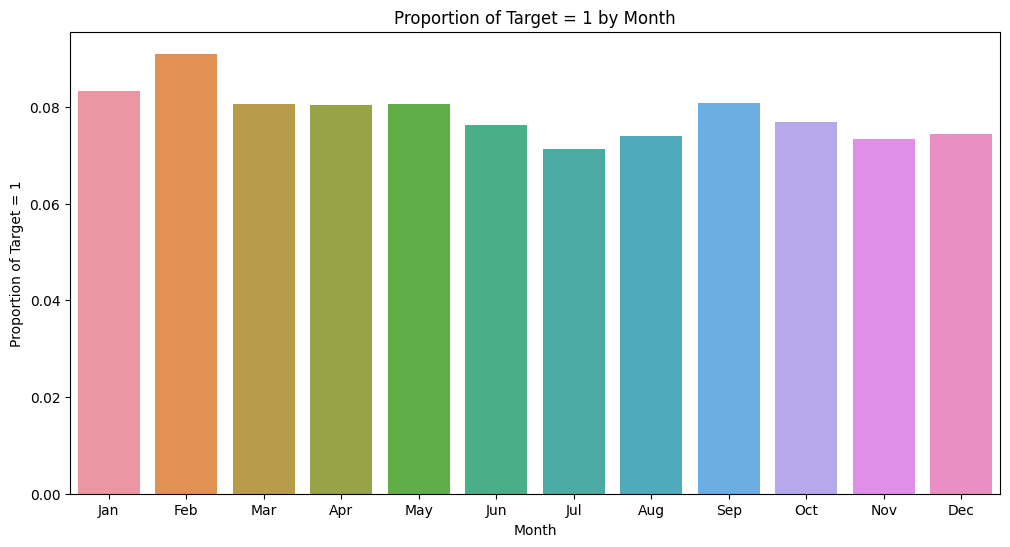

Chi-Square p-value for target grouped by month: 0.0


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


# Group by year and month, and calculate the proportion of target = 1
df_month = df.groupby(['invoice_month'])['target'].mean().reset_index()

# Renaming columns for better readability
df_month.rename(columns={'invoice_month': 'month', 'target': 'proportion_target_1'}, inplace=True)

# Plotting the barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_month, x='month', y='proportion_target_1')
plt.title('Proportion of Target = 1 by Month')
plt.ylabel('Proportion of Target = 1')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.show()

# Performing Chi-Square test
def chi_square_test(df, group_col, target_col):
    contingency_table = pd.crosstab(df[group_col], df[target_col])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    return p

# Chi-Square p-value for target grouped by month
p_value = chi_square_test(df, 'invoice_month', 'target')
print(f'Chi-Square p-value for target grouped by month: {p_value}')


In [14]:
# Loop through each month and analyze
for month in range(1, 13):
    month_data = df[df['invoice_month'] == month]
    target_proportion = month_data['target'].mean()
    print(f'Month: {month}, Proportion of Target = 1: {target_proportion:.2f}')


Month: 1, Proportion of Target = 1: 0.08
Month: 2, Proportion of Target = 1: 0.09
Month: 3, Proportion of Target = 1: 0.08
Month: 4, Proportion of Target = 1: 0.08
Month: 5, Proportion of Target = 1: 0.08
Month: 6, Proportion of Target = 1: 0.08
Month: 7, Proportion of Target = 1: 0.07
Month: 8, Proportion of Target = 1: 0.07
Month: 9, Proportion of Target = 1: 0.08
Month: 10, Proportion of Target = 1: 0.08
Month: 11, Proportion of Target = 1: 0.07
Month: 12, Proportion of Target = 1: 0.07


## feature selection 

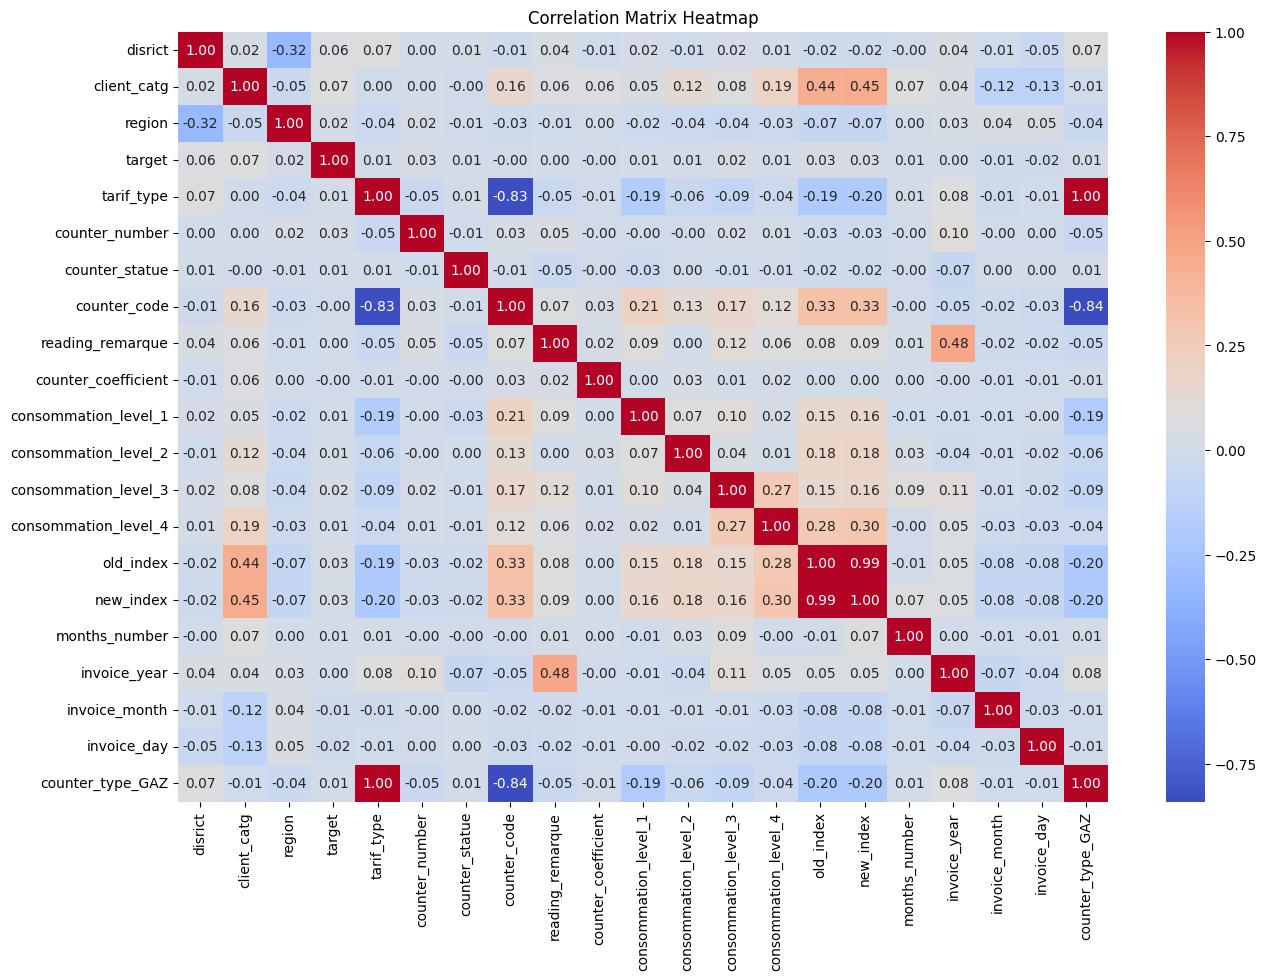

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


In [16]:
# drop tarif type and old index 
df = df.drop(["tarif_type", "old_index"], axis=1)


In [17]:
df.dtypes

disrict                 int64
client_catg             int64
region                  int64
target                  int32
counter_number          int64
counter_statue          int64
counter_code            int64
reading_remarque        int64
counter_coefficient     int64
consommation_level_1    int64
consommation_level_2    int64
consommation_level_3    int64
consommation_level_4    int64
new_index               int64
months_number           int64
invoice_year            int32
invoice_month           int32
invoice_day             int32
counter_type_GAZ        int32
dtype: object

In [18]:
## Baseline model 

## Scaling

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X=df.drop("target",axis=1)# Split the data
y=df["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## baseline model 

Logistic Regression Model Performance:
Accuracy: 0.9212283938759007
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    824834
           1       0.38      0.00      0.00     70514

    accuracy                           0.92    895348
   macro avg       0.65      0.50      0.48    895348
weighted avg       0.88      0.92      0.88    895348

Confusion Matrix:
 [[824799     35]
 [ 70493     21]]
AUC: 0.6012992470699206


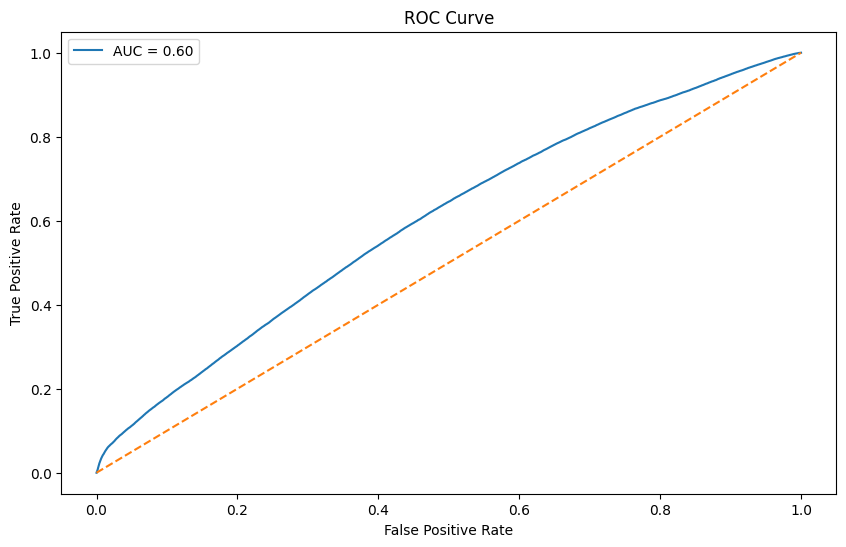

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score, roc_curve

# Create the Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logreg.fit(X_train_scaled, y_train)

# Predict using the logistic regression model
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Evaluate the logistic regression model
print("Logistic Regression Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# deal with class imbalance 

In [21]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Use SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# Baseline Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logreg.fit(X_res, y_res)
logreg_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]
print("Logistic Regression AUC:", roc_auc_score(y_test, logreg_pred_proba))


Logistic Regression AUC: 0.6019468026440605


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [ ]:
"""# Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_res, y_res)
rf_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]
print("Random Forest AUC:", roc_auc_score(y_test, rf_pred_proba))"""


'# Random Forest\nrf = RandomForestClassifier(random_state=42, class_weight=\'balanced\')\nrf.fit(X_res, y_res)\nrf_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]\nprint("Random Forest AUC:", roc_auc_score(y_test, rf_pred_proba))'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)



# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight='balanced',max_features='sqrt', max_leaf_nodes=10, bootstrap=True, n_jobs=1,verbose=0)

# Define the k-fold cross-validation method
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=kf, scoring='roc_auc')

# Fit the model
grid_search_rf.fit(X_scaled, y_res)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest:", best_params_rf)

# Train the final model with the best parameters
rf_best = RandomForestClassifier(**best_params_rf, random_state=42, class_weight='balanced')
rf_best.fit(X_scaled, y_res)
rf_pred_proba = rf_best.predict_proba(X_test_scaled)[:, 1]
print("Random Forest AUC after tuning:", roc_auc_score(y_test, rf_pred_proba))
